In [1]:
import os
import joblib
import pickle

import pandas as pd
import numpy as np

pd.options.display.max_rows = 100

In [2]:
artifacts_fpath = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/adapter_artifacts'

## Logistic Regression

#### Performance of Logistic Regression Models trained on Count-based representations (count-LR), CLMBR_GRU, CLMBR_tansformer, as well as end-to-end(ETE)_GRU and ETE_transformer
- within each figure panel, the first sub-panel is the ID performance (2009-2012), and the second and third panels are OOD performance (2013-2016 and 2017-2021)

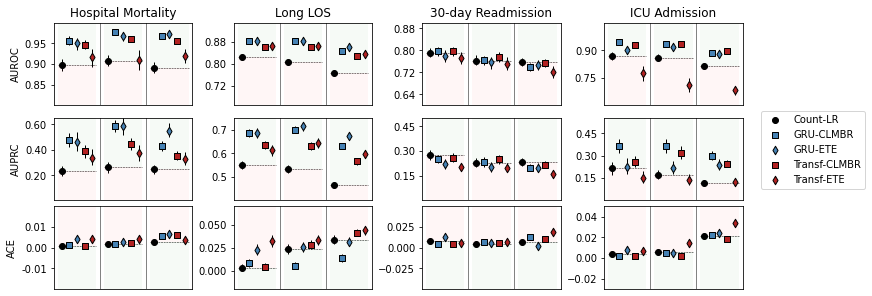

In [3]:
from utils_visualize import plot_perf_grouped

encoders = {
    'gru':'GRU',
    'transformer':'Transformer',
}

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission'
}

y_axis = {
    'auc':{
        'hospital_mortality':[0.8,1],
        'LOS_7':[0.65,0.95],
        'readmission_30':[0.6,0.9],
        'icu_admission':[0.6,1.05],
    },
    'auprc_c':{
        'hospital_mortality':[0,0.65],
        'LOS_7':[0.4,0.75],
        'readmission_30':[0,0.5],
        'icu_admission':[0,0.55],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.03, 0.03],
        'LOS_7':[-0.02, 0.07],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.03, 0.05],
    },
}

metrics = {
    'auc':'AUROC',
    'auprc_c':'AUPRC',
    'ace_abs_logistic_logit':'ACE',
}

df = plot_perf_grouped(
    artifacts_fpath=artifacts_fpath,
    tasks=tasks,
    metrics=metrics,
    encoders=encoders,
    y_axis=y_axis,
    figsize=(12,4),
    legend_bbox_to_anchor=(1.1, 1.15),
    legend_ncols=1,
    fill_alpha=0.035,
    #save_path='figs/09_12_perf_lr_grouped.png'
)

#### ID and OOD performance of CLMBR_GRU, CLMBR_transformer, ETE_GRU, and ETE_transformer relative to count-LR models

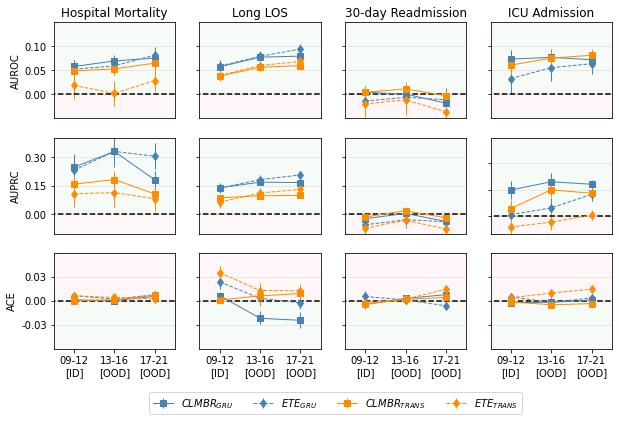

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter

y_axis = {
    'auc':{
        'hospital_mortality':[-0.05, 0.15],
        'LOS_7':[-0.05, 0.15],
        'readmission_30':[-0.05, 0.15],
        'icu_admission':[-0.05, 0.15],
    },
    'auprc_c':{
        'hospital_mortality':[-0.1, 0.4],
        'LOS_7':[-0.1, 0.4],
        'readmission_30':[-0.1, 0.4],
        'icu_admission':[-0.1, 0.445],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.05, 0.05],
        'LOS_7':[-0.05, 0.05],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.05, 0.05],
    },
}

models = {
    'gru':{'label':'$CLMBR_{GRU}$', 'color':'steelblue', 'linestyle':'-', 'markerstyle':'s'},
    'gru_ete':{'label':'$ETE_{GRU}$', 'color':'steelblue', 'linestyle':'--', 'markerstyle':'d'},
    'transformer':{'label':'$CLMBR_{TRANS}$', 'color':'darkorange', 'linestyle':'-', 'markerstyle':'s'},
    'transformer_ete':{'label':'$ETE_{TRANS}$', 'color':'darkorange', 'linestyle':'--', 'markerstyle':'d'}
}

plot_encoders = ['gru','gru_ete','transformer','transformer_ete']

fig,axes=plt.subplots(nrows=len(metrics),ncols=len(tasks),figsize=(10,6),constrained_layout=False)

for c,task in enumerate(tasks):
    for r,metric in enumerate(metrics):
        
        # stack selected models
        temp_stacked = pd.DataFrame()
        for encoder in plot_encoders:
            temp = df.query("task==@task and metric==@metric and encoder==['count',@encoder]")
            temp = temp.pivot_table(values='performance',index=['test_group','boot_num'],columns='encoder').reset_index()
            temp = temp.assign(
                delta = temp[encoder]-temp['count'],
            )
        
            temp_stacked =  pd.concat((
                temp_stacked,
                temp[['test_group','delta']].assign(model=encoder)
            ))
        
        temp_stacked = (
            temp_stacked
            .groupby(['model','test_group'])
            .quantile([0.025,0.5,0.975])
            .unstack()
            .reset_index()
            .replace({'09-12':'09-12\n[ID]', '13-16':'13-16\n[OOD]', '17-21':'17-21\n[OOD]' })
        )
        
        temp_stacked = temp_stacked.assign(
            median = temp_stacked[('delta', 0.5)],
            lower = np.abs(temp_stacked[('delta', 0.025)] - temp_stacked[('delta', 0.5)]),
            upper = np.abs(temp_stacked[('delta', 0.975)] - temp_stacked[('delta', 0.5)]),
        )

        for m,model in enumerate(plot_encoders):
            
            x = temp_stacked.test_group.unique()
            y = temp_stacked[temp_stacked['model']==model]['median']
            e = temp_stacked[temp_stacked['model']==model][['lower','upper']].values.T
            
            axes[r][c].errorbar(
                x,y,e,linewidth=1,
                marker=models[model]['markerstyle'],
                markerfacecolor=models[model]['color'],
                color=models[model]['color'],
                linestyle=models[model]['linestyle'],
                label=models[model]['label'],
            )
            
            if m==0:
                h_hatch_1 = axes[r][c].fill_between(
                    [-1,len(x)],
                    [-5, -5] if metric in ['auc','auprc','auprc_c'] else [5,5],
                    0,
                    facecolor='red',
                    #facecolor=None,
                    #hatch='///',
                    #edgecolor='red',
                    linewidth=0,
                    alpha=0.03,
                    interpolate=True,
                    zorder=0,
                )

                h_hatch_2 = axes[r][c].fill_between(
                    [-1,len(x)],
                    [5, 5] if metric in ['auc','auprc','auprc_c'] else [-5, -5],
                    0,
                    facecolor='green',
                    #facecolor=None,
                    #hatch='XXX',
                    #edgecolor='green',
                    linewidth=0,
                    alpha=0.03,
                    interpolate=True,
                    zorder=0,
                )
            
            

        axes[r][c].plot([-1,len(x)],[0,0],'k--')
        
        
        axes[r][c].set_xlim([-0.5,2.5])
        axes[r][c].set_ylim(y_axis[metric][task])
        axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y', alpha = 0.5)
        
        if c==0:
            axes[r][c].set_ylabel(metrics[metric])
        else:
            axes[r][c].set_yticklabels('')
        
        if r==0:
            axes[r][c].set_title(tasks[task])
            
        if r!=len(metrics)-1:
            axes[r][c].set_xticks('')
            
        if r == len(metrics)-1 and c == len(tasks)-1:
            leg = axes[r][c].legend(
                bbox_to_anchor=(0.3,-0.4),
                ncol=len(plot_encoders),
            )

#plt.savefig('figs/09_12_perf_lr_relative.png', dpi=300, bbox_inches='tight', pad_inches=1)         
plt.show()

#### Difference in OOD (2017-2021) to ID (2009-2012) performance of Logistic Regression Models trained on Count-based representations, GRU-based CLMBR, Transformer-based CLMBR, as well as GRU-ETE and Transformer-ETE

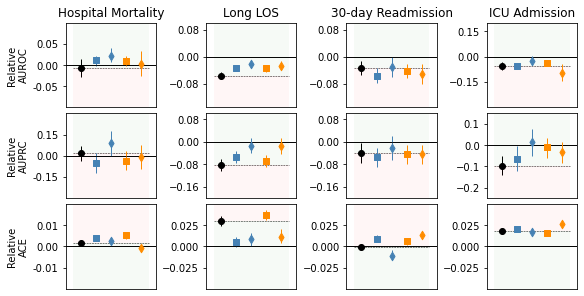

In [5]:
from utils_visualize import plot_perf_grouped_ood_rel

encoders = {
    'gru':'GRU',
    'transformer':'Transformer',
}

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission'
}

y_axis = {
    'auc':{
        'hospital_mortality':[-0.1, 0.1],
        'LOS_7':[-0.15, 0.1],
        'readmission_30':[-0.15, 0.1],
        'icu_admission':[-0.3, 0.2],
    },
    'auprc_c':{
        'hospital_mortality':[-0.3, 0.3],
        'LOS_7':[-0.2, 0.1],
        'readmission_30':[-0.2, 0.1],
        'icu_admission':[-0.25, 0.15],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.03, 0.03],
        'LOS_7':[-0.05, 0.05],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.05, 0.05],
    },
}

metrics = {
    'auc':'Relative\nAUROC',
    'auprc_c':'Relative\nAUPRC',
    'ace_abs_logistic_logit':'Relative\nACE',
}

df = plot_perf_grouped_ood_rel(
    artifacts_fpath=artifacts_fpath,
    tasks=tasks,
    metrics=metrics,
    encoders=encoders,
    y_axis=y_axis,
    figsize=(8,4),
    legend_bbox_to_anchor=(1.1, 0.435),
    legend_ncols=1,
    fill_alpha=0.035,
    show_legend=False,
    groups={'2017_2018_2019_2020_2021':'17-21'},
    #save_path='figs/09_12_perf_lr_grouped_OOD.png'
)

## LightGBM

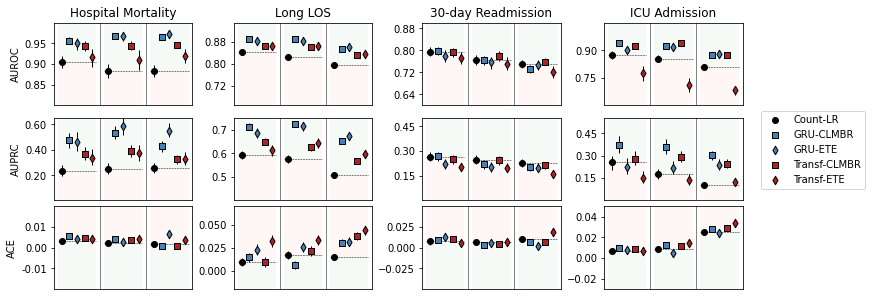

In [6]:
from utils_visualize import plot_perf_grouped

encoders = {
    'gru':'GRU',
    'transformer':'Transformer',
}

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission'
}

y_axis = {
    'auc':{
        'hospital_mortality':[0.8,1],
        'LOS_7':[0.65,0.95],
        'readmission_30':[0.6,0.9],
        'icu_admission':[0.6,1.05],
    },
    'auprc_c':{
        'hospital_mortality':[0,0.65],
        'LOS_7':[0.4,0.75],
        'readmission_30':[0,0.5],
        'icu_admission':[0,0.55],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.03, 0.03],
        'LOS_7':[-0.02, 0.07],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.03, 0.05],
    },
}

metrics = {
    'auc':'AUROC',
    'auprc_c':'AUPRC',
    'ace_abs_logistic_logit':'ACE',
}

df = plot_perf_grouped(
    artifacts_fpath=artifacts_fpath,
    tasks=tasks,
    metrics=metrics,
    encoders=encoders,
    model='gbm',
    y_axis=y_axis,
    figsize=(12,4),
    legend_bbox_to_anchor=(1.1, 1.15),
    legend_ncols=1,
    fill_alpha=0.035,
    #save_path='figs/09_12_perf_gbm_grouped.png'
)

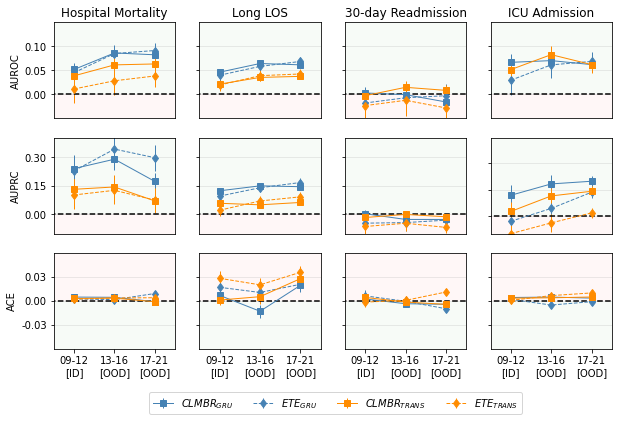

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter

y_axis = {
    'auc':{
        'hospital_mortality':[-0.05, 0.15],
        'LOS_7':[-0.05, 0.15],
        'readmission_30':[-0.05, 0.15],
        'icu_admission':[-0.05, 0.15],
    },
    'auprc_c':{
        'hospital_mortality':[-0.1, 0.4],
        'LOS_7':[-0.1, 0.4],
        'readmission_30':[-0.1, 0.4],
        'icu_admission':[-0.1, 0.445],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.05, 0.05],
        'LOS_7':[-0.05, 0.05],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.05, 0.05],
    },
}

models = {
    'gru':{'label':'$CLMBR_{GRU}$', 'color':'steelblue', 'linestyle':'-', 'markerstyle':'s'},
    'gru_ete':{'label':'$ETE_{GRU}$', 'color':'steelblue', 'linestyle':'--', 'markerstyle':'d'},
    'transformer':{'label':'$CLMBR_{TRANS}$', 'color':'darkorange', 'linestyle':'-', 'markerstyle':'s'},
    'transformer_ete':{'label':'$ETE_{TRANS}$', 'color':'darkorange', 'linestyle':'--', 'markerstyle':'d'}
}

plot_encoders = ['gru','gru_ete','transformer','transformer_ete']

fig,axes=plt.subplots(nrows=len(metrics),ncols=len(tasks),figsize=(10,6),constrained_layout=False)

for c,task in enumerate(tasks):
    for r,metric in enumerate(metrics):
        
        # stack selected models
        temp_stacked = pd.DataFrame()
        for encoder in plot_encoders:
            temp = df.query("task==@task and metric==@metric and encoder==['count',@encoder]")
            temp = temp.pivot_table(values='performance',index=['test_group','boot_num'],columns='encoder').reset_index()
            temp = temp.assign(
                delta = temp[encoder]-temp['count'],
            )
        
            temp_stacked =  pd.concat((
                temp_stacked,
                temp[['test_group','delta']].assign(model=encoder)
            ))
        
        temp_stacked = (
            temp_stacked
            .groupby(['model','test_group'])
            .quantile([0.025,0.5,0.975])
            .unstack()
            .reset_index()
            .replace({'09-12':'09-12\n[ID]', '13-16':'13-16\n[OOD]', '17-21':'17-21\n[OOD]' })
        )
        
        temp_stacked = temp_stacked.assign(
            median = temp_stacked[('delta', 0.5)],
            lower = np.abs(temp_stacked[('delta', 0.025)] - temp_stacked[('delta', 0.5)]),
            upper = np.abs(temp_stacked[('delta', 0.975)] - temp_stacked[('delta', 0.5)]),
        )

        for m,model in enumerate(plot_encoders):
            
            x = temp_stacked.test_group.unique()
            y = temp_stacked[temp_stacked['model']==model]['median']
            e = temp_stacked[temp_stacked['model']==model][['lower','upper']].values.T
            
            axes[r][c].errorbar(
                x,y,e,linewidth=1,
                marker=models[model]['markerstyle'],
                markerfacecolor=models[model]['color'],
                color=models[model]['color'],
                linestyle=models[model]['linestyle'],
                label=models[model]['label']
            )
            
            if m==0:
                h_hatch_1 = axes[r][c].fill_between(
                    [-1,len(x)],
                    [-5, -5] if metric in ['auc','auprc','auprc_c'] else [5,5],
                    0,
                    facecolor='red',
                    #hatch='///',
                    #edgecolor='red',
                    linewidth=0,
                    alpha=0.03,
                    interpolate=True,
                    zorder=0,
                )

                h_hatch_2 = axes[r][c].fill_between(
                    [-1,len(x)],
                    [5, 5] if metric in ['auc','auprc','auprc_c'] else [-5, -5],
                    0,
                    facecolor='green',
                    #hatch='XXX',
                    #edgecolor='green',
                    linewidth=0,
                    alpha=0.03,
                    interpolate=True,
                    zorder=0,
                )
            
            

        axes[r][c].plot([-1,len(x)],[0,0],'k--')
        
        
        axes[r][c].set_xlim([-0.5,2.5])
        axes[r][c].set_ylim(y_axis[metric][task])
        axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y', alpha = 0.5)
        
        if c==0:
            axes[r][c].set_ylabel(metrics[metric])
        else:
            axes[r][c].set_yticklabels('')
        
        if r==0:
            axes[r][c].set_title(tasks[task])
            
        if r!=len(metrics)-1:
            axes[r][c].set_xticks('')
            
        if r == len(metrics)-1 and c == len(tasks)-1:
            leg = axes[r][c].legend(
                bbox_to_anchor=(0.3,-0.4),
                ncol=len(plot_encoders),
            )

#plt.savefig('figs/09_12_perf_gbm_relative.png', dpi=300, bbox_inches='tight', pad_inches=1)         
plt.show()

#### Relative OOD (to ID) performance of LightGBM Models trained on Count-based representations, GRU-based CLMBR, Transformer-based CLMBR, as well as GRU-ETE and Transformer-ETE

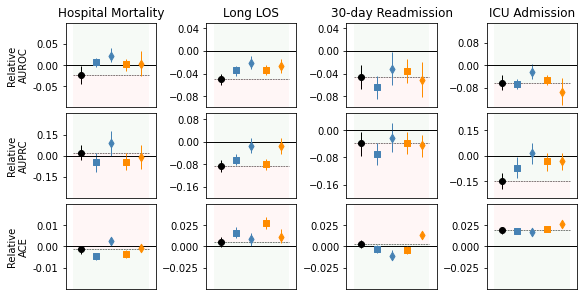

In [8]:
from utils_visualize import plot_perf_grouped_ood_rel

encoders = {
    'gru':'GRU',
    'transformer':'Transformer',
}

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission'
}

y_axis = {
    'auc':{
        'hospital_mortality':[-0.1, 0.1],
        'LOS_7':[-0.1, 0.05],
        'readmission_30':[-0.1, 0.05],
        'icu_admission':[-0.15, 0.15],
    },
    'auprc_c':{
        'hospital_mortality':[-0.3, 0.3],
        'LOS_7':[-0.2, 0.1],
        'readmission_30':[-0.2, 0.05],
        'icu_admission':[-0.25, 0.25],
    },
    'ace_abs_logistic_logit':{
        'hospital_mortality':[-0.03, 0.03],
        'LOS_7':[-0.05, 0.05],
        'readmission_30':[-0.05, 0.05],
        'icu_admission':[-0.05, 0.05],
    },
}

metrics = {
    'auc':'Relative\nAUROC',
    'auprc_c':'Relative\nAUPRC',
    'ace_abs_logistic_logit':'Relative\nACE',
}

df = plot_perf_grouped_ood_rel(
    artifacts_fpath=artifacts_fpath,
    tasks=tasks,
    metrics=metrics,
    encoders=encoders,
    y_axis=y_axis,
    figsize=(8,4),
    legend_bbox_to_anchor=(1.1, 0.435),
    legend_ncols=1,
    fill_alpha=0.035,
    show_legend=False,
    model='gbm',
    groups={'2017_2018_2019_2020_2021':'17-21'},
    #save_path='figs/09_12_perf_gbm_grouped_OOD.png'
)

#### Change in OOD performance relative to Count OOD Performance in each year from 2013-2021

    Change in OOD performance of models relative to OOD performance of baseline models trained on 09-12    Red = better robustness than count feature models, Blue = worse robustness than count feature models


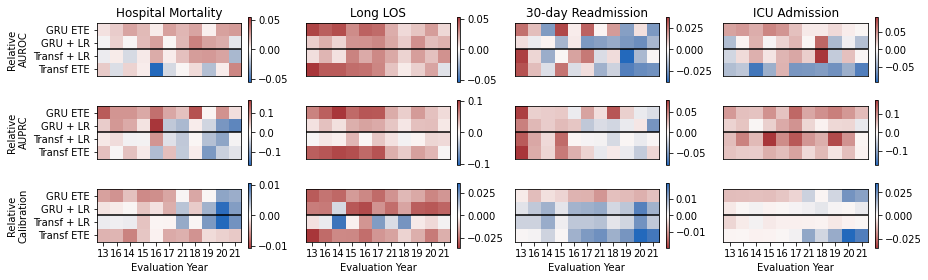

In [9]:
from utils_visualize import plot_heatmap_ood

models_dict = {
    "gru_lr": {
        'label':'GRU + LR',
    },
    "gru_ete_gru_ete": {
        'label':'GRU ETE',
    },
    "transformer_lr": {
        'label':'Transf + LR',
    },
    "transformer_ete_transformer_ete": {
        'label':'Transf ETE',
    },
    "count_lr": {
        'label':'Cnt + LR',
    },
} 

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission'
}

metrics = {
    'auc':'AUROC',
    'auprc_c':'AUPRC',
    'ace_abs_logistic_logit':'Calibration',
}

models = {
    'lr':'Logistic Regression',
}

encoders = {
    'gru':'GRU',
    'transformer':'Transformer',
}

print("\
    Change in OOD performance of models relative to OOD performance of baseline models trained on 09-12\
    Red = better robustness than count feature models, Blue = worse robustness than count feature models\
")

df_eval = plot_heatmap_ood(
    artifacts_fpath=artifacts_fpath,
    tasks=tasks,
    encoders=encoders,
    models=models,
    metrics=metrics,
    figsize=(13,4),
    y_axis='auto',
    cmap='vlag',
    models_dict=models_dict,
    normalize_by_baseline=True,
    #save_path='figs/rel_ood_heatmap.png',
)